<a href="https://colab.research.google.com/github/Radhi1999/radhika_INFO5731_Fall2022/blob/main/In_class_exercise/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 11/03/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# Write your code here
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=6c5fd98720c6a6b718ecc772dea84a3d07a6a0f3feafa17abd0574d1ef46129d
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=7a3886e2e17bc986c8a5290470ea1a96f723424a4f59be2edef33edd6cff7874
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
test_df = pd.read_csv("https://raw.githubusercontent.com/Radhi1999/radhika_INFO5731_Fall2022/main/In_class_exercise/test.csv")

#Cleaning the data
import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

test_df["Text"] = test_df["Text"].apply(cleantext)

# Convert to list
data = test_df.Text.values.tolist()

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [12]:
b = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
t = gensim.models.Phrases(b[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bmod = gensim.models.phrases.Phraser(b)
tmod = gensim.models.phrases.Phraser(t)

# See trigram example
print(tmod[bmod[data_words[0]]])

['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bmod[doc] for doc in texts]

def make_trigrams(texts):
    return [tmod[bmod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


[['optimistic', 'ability', 'prevent', 'next', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [16]:
id2word[0]

'ability'

In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.060*"work" + 0.041*"world" + 0.026*"talk" + 0.025*"time" + 0.024*"inspire" + 0.023*"make" + 0.023*"health" + 0.022*"young" + 0.020*"improve" + 0.019*"thank"'), (1, '0.046*"great" + 0.041*"learn" + 0.024*"thing" + 0.024*"even" + 0.019*"thank" + 0.017*"fight" + 0.017*"breakthrough" + 0.016*"problem" + 0.016*"science" + 0.015*"team"'), (2, '0.039*"fight" + 0.039*"disease" + 0.037*"day" + 0.030*"ever" + 0.029*"leadership" + 0.027*"alzheimer" + 0.023*"datum" + 0.021*"share" + 0.020*"first" + 0.017*"million"'), (3, '0.039*"climate_change" + 0.034*"need" + 0.034*"world" + 0.033*"make" + 0.029*"new" + 0.029*"help" + 0.024*"innovation" + 0.024*"see" + 0.023*"get" + 0.021*"take"'), (4, '0.081*"people" + 0.033*"year" + 0.030*"live" + 0.020*"change" + 0.019*"future" + 0.016*"country" + 0.016*"create" + 0.015*"poor" + 0.013*"power" + 0.013*"many"'), (5, '0.057*"energy" + 0.032*"technology" + 0.031*"partner" + 0.022*"want" + 0.022*"invest" + 0.021*"worker" + 0.018*"scientist" + 0.017*"clean"

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.418558179451499

Coherence Score:  0.3962540067031319


In [22]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

--2022-11-06 04:52:02--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-11-06 04:52:02--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.6MB/s    in 0.9s    

2022-11-06 04:52:03 (16.6 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('energy', 0.10139860139860139),
   ('technology', 0.06293706293706294),
   ('create', 0.05244755244755245),
   ('build', 0.04895104895104895),
   ('innovation', 0.045454545454545456),
   ('clean', 0.045454545454545456),
   ('breakthrough', 0.038461538461538464),
   ('accelerate', 0.03671328671328671),
   ('economy', 0.03496503496503497),
   ('job', 0.027972027972027972)]),
 (10,
  [('year', 0.24271844660194175),
   ('learn', 0.11262135922330097),
   ('change', 0.04271844660194175),
   ('case', 0.03300970873786408),
   ('lesson', 0.031067961165048542),
   ('death', 0.02912621359223301),
   ('enjoy', 0.02912621359223301),
   ('put', 0.02524271844660194),
   ('wait', 0.02524271844660194),
   ('play', 0.02330097087378641)]),
 (8,
  [('avoid', 0.07692307692307693),
   ('leadership', 0.0695970695970696),
   ('great', 0.0695970695970696),
   ('climate_disaster', 0.06776556776556776),
   ('emission', 0.06593406593406594),
   ('innovation', 0.0641025641025641),
   ('reduce', 0.03479853

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

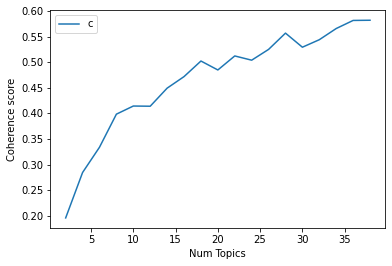

In [26]:
 # Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1958
Num Topics = 4  has Coherence Value of 0.2845
Num Topics = 6  has Coherence Value of 0.334
Num Topics = 8  has Coherence Value of 0.3986
Num Topics = 10  has Coherence Value of 0.4145
Num Topics = 12  has Coherence Value of 0.4142
Num Topics = 14  has Coherence Value of 0.4495
Num Topics = 16  has Coherence Value of 0.4721
Num Topics = 18  has Coherence Value of 0.5025
Num Topics = 20  has Coherence Value of 0.4851
Num Topics = 22  has Coherence Value of 0.5125
Num Topics = 24  has Coherence Value of 0.5042
Num Topics = 26  has Coherence Value of 0.5253
Num Topics = 28  has Coherence Value of 0.5571
Num Topics = 30  has Coherence Value of 0.5296
Num Topics = 32  has Coherence Value of 0.5442
Num Topics = 34  has Coherence Value of 0.5661
Num Topics = 36  has Coherence Value of 0.5819
Num Topics = 38  has Coherence Value of 0.5823


In [28]:
# Select the model and print the topics
optimal_model = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
# Since I have decided 10 to be the ideal number of topics, Topics number 30 is present in the 14th place of the list.
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(5,
  '0.104*"today" + 0.086*"student" + 0.068*"support" + 0.068*"give" + '
  '0.058*"learn" + 0.048*"back" + 0.046*"teacher" + 0.033*"meet" + '
  '0.025*"join" + 0.025*"school"'),
 (27,
  '0.119*"avoid" + 0.105*"climate_disaster" + 0.074*"stop" + 0.040*"require" + '
  '0.031*"approach" + 0.028*"area" + 0.028*"breakthrough" + 0.025*"hopeful" + '
  '0.023*"list" + 0.023*"encourage"'),
 (13,
  '0.247*"world" + 0.070*"leadership" + 0.070*"poverty" + 0.052*"solution" + '
  '0.038*"change" + 0.038*"team" + 0.032*"join" + 0.026*"tough" + 0.023*"plan" '
  '+ 0.023*"bring"'),
 (20,
  '0.218*"climate_change" + 0.141*"innovation" + 0.089*"emission" + '
  '0.045*"power" + 0.040*"reduce" + 0.037*"sector" + 0.035*"carbon" + '
  '0.030*"electricity" + 0.022*"worst_effect" + 0.020*"source"'),
 (22,
  '0.247*"make" + 0.068*"hope" + 0.053*"start" + 0.038*"safe" + '
  '0.035*"potential" + 0.021*"powerful" + 0.021*"shape" + 0.018*"quickly" + '
  '0.018*"win" + 0.018*"remind"'),
 (12,
  '0.223*"pandemic"

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [29]:
# Write your code here
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [30]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)

[['optimist',
  'abil',
  'prevent',
  'next',
  'pandem',
  'learn',
  'much',
  'covid',
  'innov',
  'tremend'],
 ['global',
  'fund',
  'one',
  'best',
  'invest',
  'global',
  'health',
  'fulli',
  'fund',
  'program',
  'next',
  'year',
  'critic',
  'end',
  'hiv',
  'tb',
  'malaria',
  'help',
  'ensur',
  'covid',
  'last',
  'pandem'],
 ['end',
  'day',
  'paul',
  'last',
  'impact',
  'found',
  'patient',
  'love',
  'dearli',
  'peopl',
  'aliv',
  'today',
  'dedic',
  'life',
  'help'],
 ['work',
  'continu',
  'partner',
  'health',
  'incred',
  'organ',
  'co',
  'found',
  'phenomen',
  'legaci'],
 ['paul',
  'never',
  'happier',
  'care',
  'patient',
  'one',
  'clinic',
  'help',
  'creat',
  'heart',
  'goe',
  'famili',
  'friend',
  'colleagu',
  'peopl',
  'whose',
  'live',
  'touch'],
 ['devast',
  'loss',
  'paul',
  'hero',
  'fortun',
  'call',
  'friend',
  'never',
  'known',
  'anyon',
  'passion',
  'reduc',
  'world',
  'worst',
  'inequ',
  '

In [31]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [32]:
number_of_topics=7
words=10

In [33]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [34]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [35]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

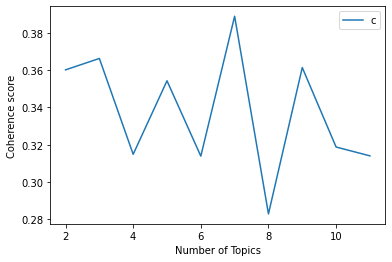

In [36]:
start,stop,step=2,12,1
plot_graph(preprocess_data(data),start,stop,step)

In [37]:
# Write your code here
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)

[(0, '-0.361*"world" + -0.306*"climat" + -0.235*"work" + -0.221*"chang" + -0.185*"help" + -0.179*"need" + -0.176*"one" + -0.153*"peopl" + -0.152*"year" + -0.143*"make"'), (1, '0.574*"climat" + 0.376*"chang" + -0.216*"health" + -0.174*"year" + -0.164*"countri" + 0.156*"avoid" + 0.142*"disast" + 0.138*"energi" + 0.130*"need" + -0.127*"vaccin"'), (2, '0.577*"world" + -0.472*"year" + -0.342*"one" + -0.220*"book" + -0.155*"new" + 0.143*"health" + -0.129*"read" + -0.096*"lot" + 0.094*"around" + -0.091*"learn"'), (3, '-0.527*"world" + 0.245*"countri" + -0.228*"year" + 0.220*"health" + 0.207*"need" + 0.192*"help" + 0.189*"vaccin" + 0.188*"pandem" + -0.151*"one" + 0.149*"covid"'), (4, '-0.637*"work" + 0.331*"one" + -0.214*"year" + 0.204*"help" + -0.192*"health" + 0.171*"peopl" + 0.149*"new" + 0.148*"world" + 0.105*"diseas" + -0.103*"foundat"'), (5, '-0.305*"chang" + 0.284*"make" + 0.261*"new" + 0.259*"energi" + -0.243*"one" + -0.230*"climat" + -0.220*"peopl" + -0.173*"countri" + 0.171*"zero" + 

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [39]:
# Write your code here
%%capture
!pip install bertopic

In [40]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [41]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

2022-11-06 05:44:22,740 - BERTopic - Transformed documents to Embeddings
2022-11-06 05:45:11,296 - BERTopic - Reduced dimensionality
2022-11-06 05:45:49,154 - BERTopic - Clustered reduced embeddings


In [42]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,6494,-1_to_the_of_and
1,0,1837,0_game_team_games_he
2,1,592,1_key_clipper_chip_encryption
3,2,527,2_ites_cheek_yep_huh
4,3,474,3_israel_israeli_jews_arab


In [43]:
topic_model.get_topic(0)

[('game', 0.010414391712044608),
 ('team', 0.009068133327414742),
 ('games', 0.007222809549628958),
 ('he', 0.007092210065039558),
 ('players', 0.006343396024703711),
 ('season', 0.006273973174756597),
 ('hockey', 0.006174537634515565),
 ('play', 0.005796880730339077),
 ('25', 0.00567575974751578),
 ('year', 0.005649545598918483)]

In [45]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [46]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [47]:
similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

[5, 154, 51, 123, 14]

In [48]:
topic_model.get_topic(71)

[('prozac', 0.011155553163175727),
 ('polio', 0.010092886565086107),
 ('patients', 0.009504002698626168),
 ('pain', 0.006976111262909947),
 ('effects', 0.006625744149954004),
 ('postpolio', 0.006506407939082817),
 ('motor', 0.006448217812473629),
 ('her', 0.00616481630121004),
 ('zoloft', 0.005869774662663649),
 ('side effects', 0.005865768078196909)]

In [49]:
# Save model
topic_model.save("my_model")	

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [50]:
# Load model
my_model = BERTopic.load("my_model")

In [51]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [52]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [53]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

query_embedding = model.encode('How big is London')
passage_embedding = model.encode(['London has 9,787,426 inhabitants at the 2011 census',
                                  'London is known for its finacial district'])

print("Similarity:", util.dot_score(query_embedding, passage_embedding))

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Similarity: tensor([[0.5472, 0.6330]])


## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)
'''Topic Coherence is a term that can be used to assess topic modeling. There are numerous methods for obtaining topic models. They are lda2vec, BERTopic, Latent Semantic Analysis (LSA), and Latent Dirichlet Allocation (LDA).

Dictionary and corpus data are the two primary inputs to the LDA topic model. Each word in the document has its own own id thanks to Gensim. We need to include the number of topics in addition to the corpus and dictionary.
Using the LDA visualization tool pyLDAvis, we can compare the outcomes of testing a variety of themes.
One of the key methods for estimating the number of subjects is topic coherence.
We must create numerous LDA models with various topic number values (k) choose the one that provides the highest coherence rating. Choosing a "k" that denotes the end of a rapid development in topic coherence typically results in themes that are meaningful and comprehensible.
The relationship between coherence value and topic count demonstrates that the coherence score drops as topics are added.
The optimal topic score is 10, and the coherence value for the data obtained using the LDA technique is 0.59.

LSA: LSA is frequently applied as a technique for noise or dimension reduction.
Topic coherence measure, a practical metric for identifying the number of topics, is the best technique to find k (number of topics) in topic modeling.
A good topic model will be one with a high topic coherence score model value.
The LSA algorithm's optimal coherence score for the plot, which is the coherence value and number of topics, is seen at 0,43 with topic at 6.

According to the analysis, LDA produces superior outcomes to LSA.'''


